<a href="https://colab.research.google.com/github/Ravi19911992/Springboard-Capstone-2/blob/master/Fastai_ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai import *
from fastai.text import *
import pandas as pd

In [0]:
#Loading the dataset from the final.csv file through read_csv
df = pd.read_csv('final.csv', index_col=None)
df.head()

,gender,Tweets,Tweets_cleaned_lemmatized
0,male,Robbie E Responds To Critics After Win Against...,robbie e responds critics win eddie edwards wo...
1,male,ÛÏIt felt like they were my friends and I was...,felt like friends living story arnge yhno reti...
2,male,Hi @JordanSpieth - Looking at the url - do you...,hi jordanspieth looking url use ifttt typicall...
3,female,Watching Neighbours on Sky+ catching up with t...,watching neighbours sky catching neighbs xxx r...
4,female,"Ive seen people on the train with lamps, chair...",ive seen people train lamps chairs tvs etc w z...


In [0]:
#copying the original DataFrame to another dataframe to work on our code.
sub_df = df.copy()

In [0]:
sub_df.drop(columns=['Tweets_cleaned_lemmatized'], axis=1, inplace=True)

In [0]:
sub_df.rename(columns={'gender': 'label' , 'Tweets' : 'text'}, inplace=True)
sub_df.head(5)

,label,text
0,male,Robbie E Responds To Critics After Win Against...
1,male,ÛÏIt felt like they were my friends and I was...
2,male,Hi @JordanSpieth - Looking at the url - do you...
3,female,Watching Neighbours on Sky+ catching up with t...
4,female,"Ive seen people on the train with lamps, chair..."


Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. It is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones. Let us now see how this works.

In [0]:
# split data into training validation set
from sklearn.model_selection import train_test_split

sub_df_trn, sub_df_val = train_test_split(sub_df, stratify = sub_df['label'], test_size = 0.4, random_state = 12)

In [0]:
sub_df_trn.shape, sub_df_val.shape

((8282, 2), (5522, 2))

Here, we use TextLMDataBunch to get the data ready for a language model. This does all the necessary preprocessing behind the scene.We can create a learner object(language_model_learner) that will directly create a model, download the pretrained weights and be ready for fine-tuning. We can use the data_lm object we created earlier to fine-tune a pretrained language model.

In [0]:
# Train language model
data_lm = TextLMDataBunch.from_df(train_df = sub_df_trn, valid_df = sub_df_val, path = "")

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,4.599605,4.017120,0.324107,00:12


We save the encoder to be able to use it for classification in the next section.

In [0]:
# Save encoder to be used in classification model
learn.save_encoder('ft_enc')

Here, we use TextClasDataBunch to get the data ready for a text classifier. We now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder. The learner object can be done in a single line.

In [0]:
# Build classifier
data_clas = TextClasDataBunch.from_df(train_df = sub_df_trn, valid_df = sub_df_val, path=".", vocab=data_lm.train_ds.vocab, bs=32)

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8282 items)
x: TextList
xxbos xxmaj yes ! xxmaj the tax credits will be delayed . xxmaj some form of victory . # taxcredits xxmaj freelance journalist : xxmaj manga critic for xxunk , editor of xxunk , administrator for xxunk , has xxmaj xxunk 's etc .,xxbos xxunk yeah , the fact that they know it 's disrespectful and still do it xxunk me bad bitch with cruel intentions # xxunk # protecttranslives,xxbos 1 new follower in the last day and it is more than just stats , i use it for growing my account ! xxmaj try it https : / / t.co / xxunk xxmaj you are my life i love you i admire you i helped with your voice in the dark moments @luke5sos,xxbos xxmaj typhoon xxmaj koppu death xxunk reaches 54 as xxmaj philippines battles devastating floods - theû _ https : / / t.co / xxunk # xxmaj typhoon xxmaj latest typhoon news and updates from the xxmaj philippines .,xxbos xxunk heard this new ones boss so gon na watch the 3 xxmaj daniel xxmaj cra

In [0]:
# train final layers
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.897622,0.782451,0.634009,00:09


Like a computer vision model, we can then unfreeze the model and fine-tune it.

In [0]:
# unfreeze model and fine tune it
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.866165,0.746524,0.655016,00:11


In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.789243,0.694441,0.688881,00:18


To improve the accuracy further, we use freeze_to method with different layers in it. We don't unfreeze the whole thing but to unfreeze one layer at a time. 
unfreeze the last two layers freeze_to(-2), train it a little bit more.
unfreeze the next layer freeze_to(-3), train it a little bit more.
unfreeze the whole thing unfreeze(), train it a little bit more.

In [0]:
# unfreeze model and fine tune it
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/2., 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.729154,0.667992,0.692322,00:14


In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/100, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.667758,0.660029,0.705541,00:18


We can see that after training for a few layers here, the accuracy jumped to almost 7% more than the original. This is a technique used in Transfer Learning. The Validation loss and the training loss decreased too. Here it is important to note that we are exactly not overfitting the data because the training and validation loss are almost the same, so we don't have to train the model more.

In [0]:
from fastai.vision import *
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

Plotting the confusion matrix. Confusion-matrix is good technique to summarize the performance of a classification algorithm. We use ClassificationInterpretationclass here.

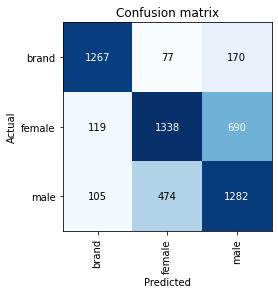

In [0]:
interp.plot_confusion_matrix()